In [1]:

library(dplyr)
library(ggplot2)
library(gridExtra)
library(tidytext)




Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
debate <- read.csv("input/debate.csv", h =T, stringsAsFactors = F)
head(debate)

Line,Speaker,Text,Date
1,Holt,"Good evening from Hofstra University in Hempstead, New York. I'm Lester Holt, anchor of ""NBC Nightly News."" I want to welcome you to the first presidential debate. The participants tonight are Donald Trump and Hillary Clinton. This debate is sponsored by the Commission on Presidential Debates, a nonpartisan, nonprofit organization. The commission drafted tonight's format, and the rules have been agreed to by the campaigns. The 90-minute debate is divided into six segments, each 15 minutes long. We'll explore three topic areas tonight: Achieving prosperity; America's direction; and securing America. At the start of each segment, I will ask the same lead-off question to both candidates, and they will each have up to two minutes to respond. From that point until the end of the segment, we'll have an open discussion. The questions are mine and have not been shared with the commission or the campaigns. The audience here in the room has agreed to remain silent so that we can focus on what the candidates are saying. I will invite you to applaud, however, at this moment, as we welcome the candidates: Democratic nominee for president of the United States, Hillary Clinton, and Republican nominee for president of the United States, Donald J. Trump.",2016-09-26
2,Audience,(APPLAUSE),2016-09-26
3,Clinton,"How are you, Donald?",2016-09-26
4,Audience,(APPLAUSE),2016-09-26
5,Holt,Good luck to you.,2016-09-26
6,Audience,(APPLAUSE),2016-09-26


How were the speakers synced with respect to response length? Here I use word count against Line as a proxy for time.



In [5]:
debate <- debate %>% 
    mutate(word_count = sapply(gregexpr("[[:alpha:]]+", Text), function(x) sum(x > 0)))

head(debate)

Line,Speaker,Text,Date,word_count
1,Holt,"Good evening from Hofstra University in Hempstead, New York. I'm Lester Holt, anchor of ""NBC Nightly News."" I want to welcome you to the first presidential debate. The participants tonight are Donald Trump and Hillary Clinton. This debate is sponsored by the Commission on Presidential Debates, a nonpartisan, nonprofit organization. The commission drafted tonight's format, and the rules have been agreed to by the campaigns. The 90-minute debate is divided into six segments, each 15 minutes long. We'll explore three topic areas tonight: Achieving prosperity; America's direction; and securing America. At the start of each segment, I will ask the same lead-off question to both candidates, and they will each have up to two minutes to respond. From that point until the end of the segment, we'll have an open discussion. The questions are mine and have not been shared with the commission or the campaigns. The audience here in the room has agreed to remain silent so that we can focus on what the candidates are saying. I will invite you to applaud, however, at this moment, as we welcome the candidates: Democratic nominee for president of the United States, Hillary Clinton, and Republican nominee for president of the United States, Donald J. Trump.",2016-09-26,210
2,Audience,(APPLAUSE),2016-09-26,1
3,Clinton,"How are you, Donald?",2016-09-26,4
4,Audience,(APPLAUSE),2016-09-26,1
5,Holt,Good luck to you.,2016-09-26,4
6,Audience,(APPLAUSE),2016-09-26,1


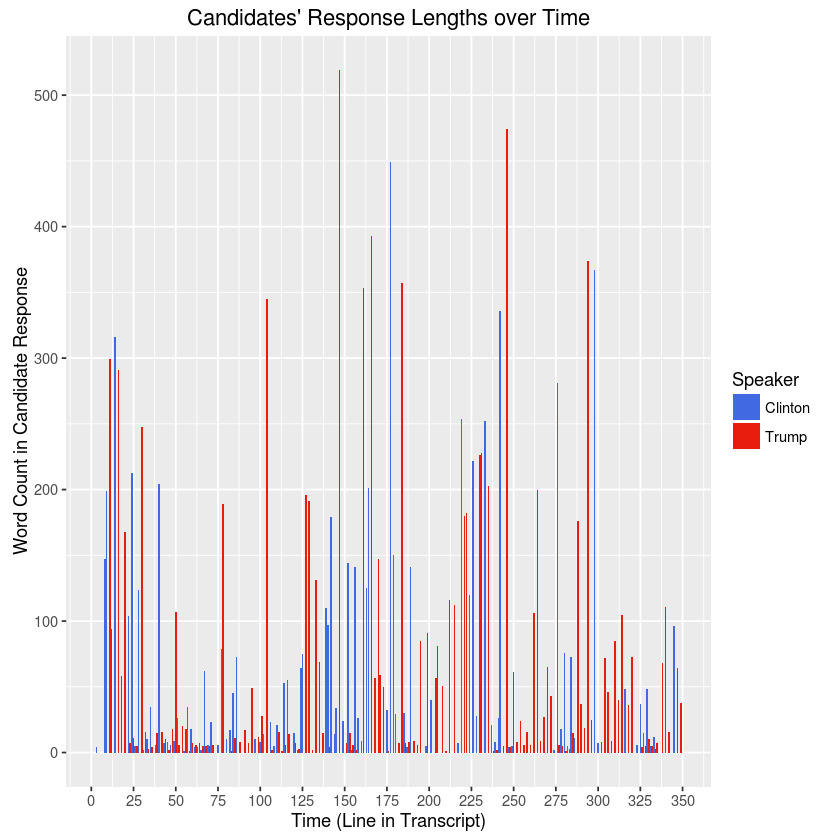

In [6]:
ggplot(debate %>% filter(Speaker %in% c("Clinton", "Trump")), 
    aes(x = Line, y = word_count, fill = Speaker)) + 

    geom_bar(stat="identity") + 

    scale_x_continuous(breaks = seq(0, nrow(debate), 25)) +

    labs(x = "Time (Line in Transcript)", 
         y = "Word Count in Candidate Response", 
         title = "Candidates' Response Lengths over Time") +

    scale_fill_manual(values = c("#4169E1", "#E91D0E"))

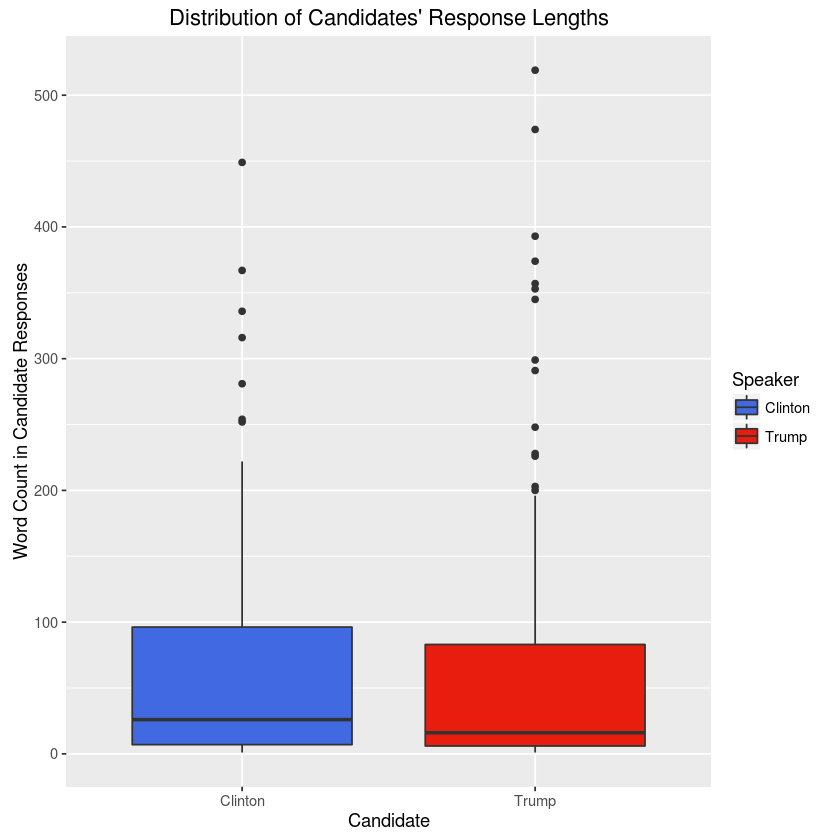

In [7]:
#What about simply looking at the distribution of their response lengths?

ggplot(debate %>% filter(Speaker %in% c("Clinton", "Trump")), 
    aes(x = Speaker, y = word_count, fill = Speaker)) +

    geom_boxplot() +

    #scale_y_log10() +

    labs(x = "Candidate", 
         y = "Word Count in Candidate Responses", 
         title = "Distribution of Candidates' Response Lengths") +

    scale_fill_manual(values = c("#4169E1", "#E91D0E"))

One thing I’ve wanted to try is tf-idf using tidy data principles as nicely demonstrated in Julia Silge’s blog here: http://juliasilge.com/blog/Term-Frequency-tf-idf/ using her tidytext library.

In [8]:
# Calculate word frequencies
debate_words <- debate %>%
    filter(Speaker %in% c("Clinton", "Trump")) %>%
    unnest_tokens(word, Text) %>%
    count(Speaker, word, sort = TRUE) %>%
    ungroup()

head(debate_words)

# Calculate tf-idf
debate_words <- debate_words %>%
    bind_tf_idf(word, Speaker, n) %>%
    arrange(desc(tf_idf)) %>%
    mutate(word = factor(word, levels = rev(unique(word))))

head(debate_words)

Speaker,word,n
Trump,and,295
Trump,the,295
Trump,to,257
Clinton,the,253
Clinton,to,239
Trump,i,239


Speaker,word,n,tf,idf,tf_idf
Trump,clinton,23,0.002685661,0.6931472,0.0018615583
Trump,leaving,15,0.001751518,0.6931472,0.0012140598
Trump,agree,14,0.001634750,0.6931472,0.0011331224
Trump,wrong,13,0.001517982,0.6931472,0.0010521851
Clinton,information,9,0.001411986,0.6931472,0.0009787142
Trump,i'll,12,0.001401214,0.6931472,0.0009712478


Selecting by tf_idf
Selecting by tf_idf


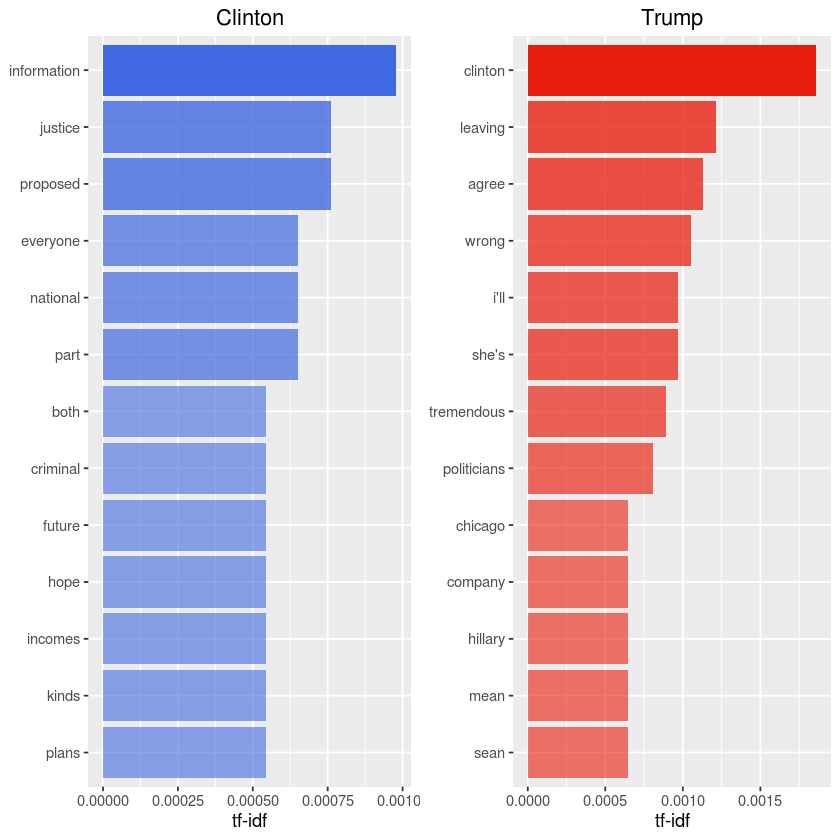

In [9]:
# Create plots of the tf-idf for each candidate
# Clinton
clinton <- ggplot(debate_words %>% 
       filter(Speaker == "Clinton") %>% 
       top_n(10),
    aes(x = word, y = tf_idf)) +
    geom_bar(aes(alpha = tf_idf), 
        stat="identity", 
        fill = "#4169E1") +
    coord_flip() +
    #scale_y_continuous(limits = c(0, 0.002)) +
    labs(x = NULL, y = "tf-idf", title = "Clinton") +
    scale_alpha_continuous(range = c(0.6, 1), guide = FALSE)

# Trump
trump <- ggplot(debate_words %>% 
       filter(Speaker == "Trump") %>% 
       top_n(10),
    aes(x = word, y = tf_idf)) +    
    geom_bar(aes(alpha = tf_idf), 
        stat="identity", 
        fill = "#E91D0E") +
    coord_flip() +
    labs(x = NULL, y = "tf-idf", title = "Trump") +
    scale_alpha_continuous(range = c(0.6, 1), guide = FALSE)

# Plot
grid.arrange(clinton, trump, ncol = 2)